In [4]:
import time, enum, math
import panel as pn
from panel import widgets as pnw
import random
import numpy as np
from numpy.random import choice
import pandas as pd
import pylab as plt
import networkx as nx
import itertools
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import bokeh.palettes
from bokeh.plotting import figure, show
from bokeh.models import Legend, LegendItem, ColumnDataSource, Grid, Line, LinearAxis, Plot
from sklearn import preprocessing
import copy
from IPython.display import display
from ipywidgets import FloatSlider, IntSlider
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import statistics

### Extra functions

In [5]:
def tournament_selection(choices, model, own_node_nr):
    '''tournament selection of neighbor'''
    if len(choices) >= 3:
        top_3_nbs = random.sample(choices, 3)
        their_weights = [model.G[nb][own_node_nr]['weight'] for nb in top_3_nbs]
        nec_dict = {k:v for k,v in zip(top_3_nbs,their_weights)}
        nec_dict_sorted = dict(sorted(nec_dict.items(), key=lambda item: item[1]))
        if choice(['y','n'], 1, p=[0.5,0.5])[0] == 'y':
            return [list(nec_dict_sorted.keys())[0]]
        elif choice(['y','n'], 1, p=[0.5*(1-0.5),1-(0.5*(1-0.5))])[0] == 'y':
            return [list(nec_dict_sorted.keys())[1]]
        else:
            return [list(nec_dict_sorted.keys())[2]]
    elif len(choices) == 2:
        their_weights = [model.G[nb][own_node_nr]['weight'] for nb in choices]
        nec_dict = {k:v for k,v in zip(choices,their_weights)}
        nec_dict_sorted = dict(sorted(nec_dict.items(), key=lambda item: item[1]))
        if choice(['y','n'], 1, p=[0.5,0.5])[0] == 'y':
            return [list(nec_dict_sorted.keys())[0]]
        else:
            return [list(nec_dict_sorted.keys())[1]]
    elif len(choices) == 1:
        return [choices[0]]
    else:
        return []
     
def patch_domination(model):
    '''get the dominant variety on each node'''
    dominant_varieties = []
    # for each node...
    for node in model.G.nodes():
        ff_test = {}
        #...loop over all possible varieties
        for i in range(model.input_len):
            # add varieties and their count to dict for this node
            ff_test['{}'.format(model.letters[i])] = len([a for a in model.G.nodes[node]['agent'] if a.variety==model.letters[i]])
        # get dominant variety for this node and store it
        thisnode_dom = max(ff_test, key=ff_test.get)
        dominant_varieties.append(thisnode_dom)
        
    return dominant_varieties 

def model_data_biological(model):
    ''' get dataframe with for each step what percentage of patches
    each variety dominates'''
    df = model.datacollector.get_model_vars_dataframe()
    df = df.reset_index()
    df = df.rename(columns={'index':'Step'})
    df = df.set_index('Step')
    # create empty columns for each variety
    for variety in model.letters[:model.input_len]:
        df[variety] = 0
    # fill in cell value percentages
    for index, row in df.iterrows():
        for col in model.letters[:model.input_len]:
            listt = df.at[index,'dominant patches']
            df.at[index,col] = listt.count(col)/len(listt)*100 
    df = df.drop(['dominant patches'], axis=1)
    return df

def run_biological_model(runs,pop,nr_steps,nb_parameter,avg_node_degree,spread_parameter,mean_age,a,b,c,d,e,f,g,h,i,j):
    '''run the plant propagation model with user-given parameter values and nr of runs'''
    inputs = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    locs = locals()
    for key in locs:
        # only check letters that have a comp advantage >= 0
        if key in letters and locs[key] >= 0:
            inputs.append(locs[key])
            
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(6)
    
    # for multiple runs
    if runs > 1:
        total_list = []
        for _ in range(runs):
            print(_)
            model = BiologicalModel(pop,nb_parameter,avg_node_degree,spread_parameter,mean_age,inputs)
            model.datacollector.collect(model)
            for i in range(nr_steps):
                model.step()

            a = model_data_biological(model)
            all_list = []
            for column in a:
                all_list.append(list(a[column]))
            total_list.append(all_list)

        for variety_index in range(len(inputs)):
            variety_list = []
            for runlist in total_list:
                variety_list.append(runlist[variety_index])
            
            means = []
            stdevs = []
            minima = []
            maxima = []
            for item in zip(*variety_list):
                means.append(statistics.mean(list(item)))
                stdevs.append(statistics.stdev(list(item)))
                minima.append(min(item))
                maxima.append(max(item))
            # plot range of vals, mean, stdev
            plt.fill_between([*range(0, nr_steps+1, 1)], minima,maxima,alpha=.3, label='{}'.format(letters[variety_index]))
            plt.errorbar([*range(0, nr_steps+1, 1)], means, stdevs, marker='.',alpha=.8)
    # for 1 run                 
    else:
        model = BiologicalModel(pop,nb_parameter,avg_node_degree,spread_parameter,mean_age,inputs)
        model.datacollector.collect(model)
        for i in range(nr_steps):
            model.step()

        a = model_data_biological(model)
        all_list = []
        for column in a:
            all_list.append(list(a[column]))
        
        for count, sublist in enumerate(all_list):
            # plot the individual lines
            plt.plot([*range(0, nr_steps+1, 1)],sublist,linewidth=3,label=letters[count])
    
    plt.xticks([0,*range(10, nr_steps+1, 10)])
    plt.yticks([*range(0, 101, 10)])
    plt.ylabel('% of patches')
    plt.xlabel('Step')
    plt.title('% of patches dominated by varieties per step in model ({} runs)'.format(runs))
    plt.legend()
    plt.show()
    
def parameter_space_biological_model(runs,nr_steps, N, nb_parameter, avg_node_degree, spread_parameter, mean_age, list_comp_advs):
    '''test the individual parameters'''
    args = locals()
    del args['runs']
    argsCOPY = copy.deepcopy(args)
    final_list = []
    for _ in range(runs):
        all_dicts = {}
        letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
        # initiate each variety as a key in a dict
        for o in range(len(list_comp_advs)):
            all_dicts[letters[o]] = []
        # get the parameter values for the x-axis
        x_axis = [v for k,v in argsCOPY.items() if type(v) == list and k != 'list_comp_advs'][0]
        # get the corresponding parameter name
        param_name = [k for k,v in argsCOPY.items() if type(v) == list and k != 'list_comp_advs'][0]
        # all parameter values
        al = [v for v in argsCOPY.values()]
        # loop <parameter values> times
        for j in range(len(x_axis)):
            results_dict = {}
            inputt = []
            for i in al[:-1]:
                if type(i) == list:
                    inputt.append(i[j])
                else:
                    inputt.append(i)
            model = BiologicalModel(*inputt[1:]+[list_comp_advs])
            for _ in range(inputt[0]):
                model.step()
            # loop <number of varieties> times   
            for k in range(len(list_comp_advs)):
                # get the corresponding variety's domination percentage for this parameter
                percentage = model_data_biological(model).iloc[-1][k]
                # store this domination percentage with the variety as the key for this parameter
                results_dict[letters[k]] = percentage
            for key,value in results_dict.items():
                all_dicts[key].append(value)
        final_list.append(all_dicts)
        
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(6)

    # loop over varieties
    d = 0
    for key in final_list[0].keys():
        variety_vals = []
        for dictionary in final_list:
            variety_vals.append(dictionary[key])
        
        means = []
        stdevs = []
        maxima = []
        minima = []
        # if param values are cardinal
        if type(x_axis[0]) == int or type(x_axis[0]) == float:
            for item in zip(*variety_vals):
                means.append(statistics.mean(list(item)))
                stdevs.append(statistics.stdev(list(item)))
                minima.append(min(item))
                maxima.append(max(item))
            # plotr range of vals, mean, stdev
            plt.fill_between(x_axis, minima, maxima,alpha=.2, label='{}'.format(key))
            plt.errorbar(x_axis, means, stdevs, marker='o')
            plt.xticks(x_axis)
        
        else:
            ind = np.arange(len(x_axis))
            width = 0.1
            for item in zip(*variety_vals):
                means.append(statistics.mean(list(item)))
                stdevs.append(statistics.stdev(list(item)))
            # plot barplot
            plt.bar(ind+(width*d), means, width, yerr=stdevs, label='{}'.format(key))
            plt.xticks(ind+width/2,x_axis)
        d += 1

    plt.xlabel(f'{param_name} parameter')
    plt.ylabel('% of patches')
    plt.title('% of patches dominated by varieties per parameter value (avg. over {} runs; {} steps per run)'.format(runs, nr_steps))
    plt.yticks([*range(0,110,10)])
    plt.legend(loc='best')
    plt.show()

### Class for agents

In [6]:
class BiologicalAgent(Agent):
    def __init__(self, unique_id, model, mother_variety):
        super().__init__(unique_id, model)
        # # initiate plant variety
        if self.model.init_val == 1:
            self.variety = choice(self.model.letters[:self.model.input_len], 1, p=[1/self.model.input_len]*self.model.input_len)[0]
        else:
            self.variety = mother_variety
        # assign competitive advantage, lifetime, and sex
        self.comp_adv = getattr(self.model,'comp_adv{}'.format(self.variety))
        self.lifetime = round(np.random.normal(self.model.mean_age,2))
        self.sex = choice(['m','f'], 1, p=[.5,.5])[0]
        # correct lifetime if < 1
        if self.lifetime < 1:
            self.lifetime = 1
        # needed for new plants that were born during the simulation
        if self.model.for_babies == 1:
            self.lifetime += 1
        
    def pollinate(self):
        patch = self.pos
        # find all female plants of same variety on this patch
        same_plants_on_patch_f = [a for a in self.model.G.nodes[patch]['agent'] if a.variety==self.variety and a.sex=='f']
        # if there are such female plants to fertilize: pick randomly to fertilize
        if len(same_plants_on_patch_f) > 0:
            fertilized_f = random.choice(same_plants_on_patch_f)
            
            # will the seed travel to the same patch, or to another connected patch?
            patch_to_choose = choice([patch,-1], 1, p=[1-self.model.spread_param,self.model.spread_param])[0]
            # if seed goes to same patch and that patch still has resources
            if patch_to_choose == patch and self.model.G.nodes[patch]['patch_resources'] > 0:
                # add new agent to this patch, and decrease patch resources with 1
                self.model.for_babies = 1
                a = BiologicalAgent(self.model.plant_id, self.model, fertilized_f.variety)
                self.model.for_babies = 0
                self.model.plant_id += 1
                self.model.schedule.add(a)
                self.model.grid.place_agent(a, patch_to_choose)
                self.model.G.nodes[patch]["patch_resources"] -= 1
            
            # if seed goes to another neighbor patch
            else:
                # all neighbors
                nbs = self.model.grid.get_neighbors(patch, include_center=False)
                
                # 1 neighbor, if there is any
                if self.model.nb_parameter == 1 and len(nbs) > 0:
                    nbs = [random.choice(nbs)]
                
                # tournament selection neighbor
                elif self.model.nb_parameter == 2:
                    nbs = tournament_selection(nbs, self.model, patch)

                # random fraction of neighbors
                elif self.model.nb_parameter == 3:
                    nbs = random.sample(nbs, random.randrange(0,len(nbs)+1))  
                    
                for patch_to_choose in nbs:
                    # if a neighbor exists and that patch still has resources and comp advantage allows for traveling that distance
                    if  self.model.G.nodes[patch_to_choose]['patch_resources'] > 0 and (self.comp_adv - self.model.G[patch_to_choose][patch]['weight']) > 0:
                        # add new agent to this patch, and decrease patch resources with 1
                        self.model.for_babies = 1
                        a = BiologicalAgent(self.model.plant_id, self.model, fertilized_f.variety)
                        self.model.for_babies = 0
                        self.model.plant_id += 1
                        self.model.schedule.add(a)
                        self.model.grid.place_agent(a, patch_to_choose)
                        self.model.G.nodes[patch_to_choose]["patch_resources"] -= 1
                    
    def decrease_life(self):
        # kill plant and increase patch resource with 1 (up to max resources)
        if self.lifetime == 1:
            self.model.G.nodes[self.pos]["patch_resources"] += 1
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
        # decrease lifetime
        else:
            self.lifetime -= 1   
        
    def step(self):
        # only male plants can pollinate
        if self.sex == 'm':
            self.pollinate()

### Class for model

In [7]:
class BiologicalModel(Model):

    def __init__(self, N, nb_parameter, avg_node_degree, spread_parameter, mean_age, list_comp_advs) :  
        # probability for edge creation
        prob = avg_node_degree / N
        self.G = nx.erdos_renyi_graph(n=N, p=prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        
        #parameters
        # interact with random nb, tournament selection, random fraction, or all nbs
        if nb_parameter == 'one':
            self.nb_parameter = 1
        elif nb_parameter == 'tournament':
            self.nb_parameter = 2
        elif nb_parameter == 'fraction':
            self.nb_parameter = 3
        elif nb_parameter == 'all':
            self.nb_parameter = 4
        else:
            raise ValueError('"neighbors" parameter does not exist.')
        # probability to spread to another patch
        self.spread_param = spread_parameter
        # mean age of plants
        self.mean_age = mean_age
        # need for newborn plants during simulation
        self.for_babies = 0
        
        self.input_len = len(list_comp_advs)
        self.letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
        # assign each variety its competitive advantage 
        for i in range(self.input_len):
             setattr(self, 'comp_adv{}'.format(self.letters[i]), list_comp_advs[i])
        
        for u, v in self.G.edges():
            # add random weights between 0 and 1
            self.G[u][v]["weight"] = random.random()
    
        # each node gets 50 resources
        resource_values = {k: v for k, v in zip(self.G.nodes(), [50]*len(self.G.nodes()))}
        nx.set_node_attributes(self.G, resource_values, "patch_resources")
        
        # needed to correctly initiate plants
        self.init_val = 1
        self.plant_id = 0
        # go over each patch
        for node in self.G.nodes():
            # add (0-max_resources) plants to each patch, and deplete resources accordingly
            for _ in range(random.randint(0,50)):
                a = BiologicalAgent(self.plant_id, self, 0)
                self.plant_id += 1
                self.schedule.add(a)
                self.grid.place_agent(a, node)
                self.G.nodes[node]["patch_resources"] -= 1
        self.init_val = 0
    
        self.datacollector = DataCollector(   
                             model_reporters= {"dominant patches": patch_domination})

    def step(self):
        # first all plants go and procreate
        self.schedule.step()
        # then all plants...
        for a in self.schedule.agents:
            # ...decrease own lifetime after each step
            a.decrease_life()
        self.datacollector.collect(self)
        

### Visualisation of steps and results for single model run

Widget for running the model with different parameter values

In [12]:
interact_manual(run_biological_model,
                runs=IntSlider(min=1, max=50, step=1, value=1),
                pop=IntSlider(min=0, max=500, step=20, value=500),
                nr_steps=IntSlider(min=0, max=200, step=10, value=150),
                nb_parameter=['one','tournament','fraction','all'],
                avg_node_degree=IntSlider(min=0, max=10, step=1, value=3),
                spread_parameter=FloatSlider(min=0, max=1, step=0.05, value=0.1),
                mean_age=IntSlider(min=1, max=10, step=1, value=5),
                a=FloatSlider(min=-1, max=1, step=0.05, value=0.5),
                b=FloatSlider(min=-1, max=1, step=0.05, value=0.5),
                c=FloatSlider(min=-1, max=1, step=0.05, value=0.5),
                d=FloatSlider(min=-1, max=1, step=0.05, value=0.5),
                e=FloatSlider(min=-1, max=1, step=0.05, value=0.5),
                f=FloatSlider(min=-1, max=1, step=0.05, value=-1),
                g=FloatSlider(min=-1, max=1, step=0.05, value=-1),
                h=FloatSlider(min=-1, max=1, step=0.05, value=-1),
                i=FloatSlider(min=-1, max=1, step=0.05, value=-1),
                j=FloatSlider(min=-1, max=1, step=0.05, value=-1));

interactive(children=(IntSlider(value=1, description='runs', max=50, min=1), IntSlider(value=500, description=…

### Individual parameter testing

Make a list with (valid!) values for the parameter that you want to test. Then input into the function, as below:

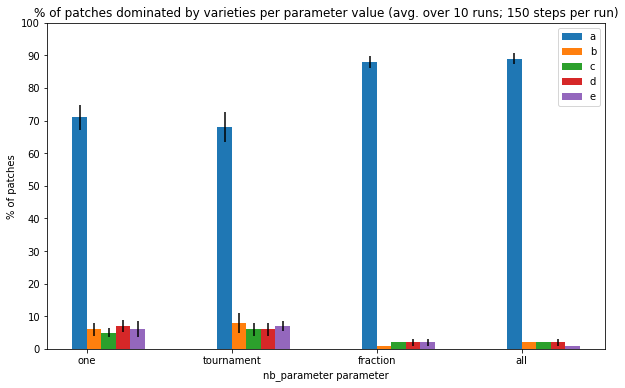

In [12]:
social_model_inputs = ['one', 'tournament', 'fraction', 'all']
parameter_space_biological_model(runs=10,nr_steps=150, N=500, nb_parameter=social_model_inputs, avg_node_degree=3,
                                 spread_parameter=0.1,mean_age=5,
                                 list_comp_advs=[0.75,0.5,0.5,0.5,0.5])

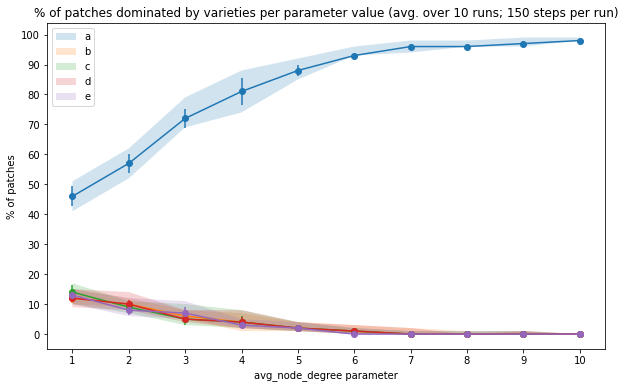

In [13]:
social_model_inputs = [1,2,3,4,5,6,7,8,9,10]
parameter_space_biological_model(runs=10,nr_steps=150, N=500, nb_parameter='one', avg_node_degree=social_model_inputs,
                                 spread_parameter=0.1,mean_age=5,
                                 list_comp_advs=[0.75,0.5,0.5,0.5,0.5])